Task:
1. Import libraries and data
2. Train pruned tree
3. Train Bagging
4. Train RF
5. Train boosting

# Importing libraries and Data
Importing top level libraries that are required for machine learning

In [62]:
import os
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots
from statsmodels.datasets import get_rdataset
import sklearn.model_selection as skm
from ISLP import load_data , confusion_table
from ISLP.models import ModelSpec as MS

from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    f1_score,
    classification_report,
)

Importing other libraries required for tree modelling 

In [47]:
from sklearn.tree import (DecisionTreeClassifier as DTC,
plot_tree ,
export_text)
from sklearn.metrics import (accuracy_score ,
log_loss)
from sklearn.ensemble import \
(RandomForestClassifier as RF,
GradientBoostingClassifier as GBC)
from ISLP.bart import BART

Data Reading

In [67]:
X_train = pd.read_csv("../data/X_train.csv")
Y_train = pd.read_csv("../data/Y_train.csv")
feature_names = X_train.columns
X_train = np.asarray(X_train)
Y_train = np.ravel(np.asarray(Y_train))

y_train = pd.read_csv("../data/y_train.csv")
X_test = pd.read_csv("../data/X_test.csv")

# Pruned Decision Tree

First, we create a very deep tree, then find the optimal value of penalty term coefficient base on cross-validation. Using this optimal alpha, we get the subtree.

In [49]:
tree = DTC(criterion='gini')
tree.fit(X_train,Y_train)

ccp_path = tree.cost_complexity_pruning_path(X_train , Y_train)
kfold = skm.KFold(10,shuffle=True)
grid = skm.GridSearchCV(tree ,{'ccp_alpha': ccp_path.ccp_alphas},refit=True ,cv=kfold ,\
                        scoring='accuracy')
grid.fit(X_train , Y_train)
grid.best_score_

0.7423016597045502

In [50]:
pruned_tree = grid.best_estimator_

We got our best pruned_tree. Let's try to plot it.

[Text(0.3997093023255814, 0.9583333333333334, 'Curricular units 2nd sem (approved) <= 3.5\ngini = 0.617\nsamples = 3539\nvalue = [1137, 643, 1759]'),
 Text(0.18604651162790697, 0.875, 'Curricular units 2nd sem (approved) <= 1.5\ngini = 0.434\nsamples = 1164\nvalue = [839, 234, 91]'),
 Text(0.11627906976744186, 0.7916666666666666, 'Curricular units 2nd sem (enrolled) <= 0.5\ngini = 0.307\nsamples = 785\nvalue = [646, 78, 61]'),
 Text(0.046511627906976744, 0.7083333333333334, 'Tuition fees up to date <= 0.5\ngini = 0.629\nsamples = 143\nvalue = [57, 25, 61]'),
 Text(0.023255813953488372, 0.625, 'gini = 0.305\nsamples = 16\nvalue = [13, 0, 3]'),
 Text(0.06976744186046512, 0.625, 'Age at enrollment <= 26.0\ngini = 0.633\nsamples = 127\nvalue = [44, 25, 58]'),
 Text(0.046511627906976744, 0.5416666666666666, 'gini = 0.629\nsamples = 121\nvalue = [38, 25, 58]'),
 Text(0.09302325581395349, 0.5416666666666666, 'gini = 0.0\nsamples = 6\nvalue = [6, 0, 0]'),
 Text(0.18604651162790697, 0.708333333

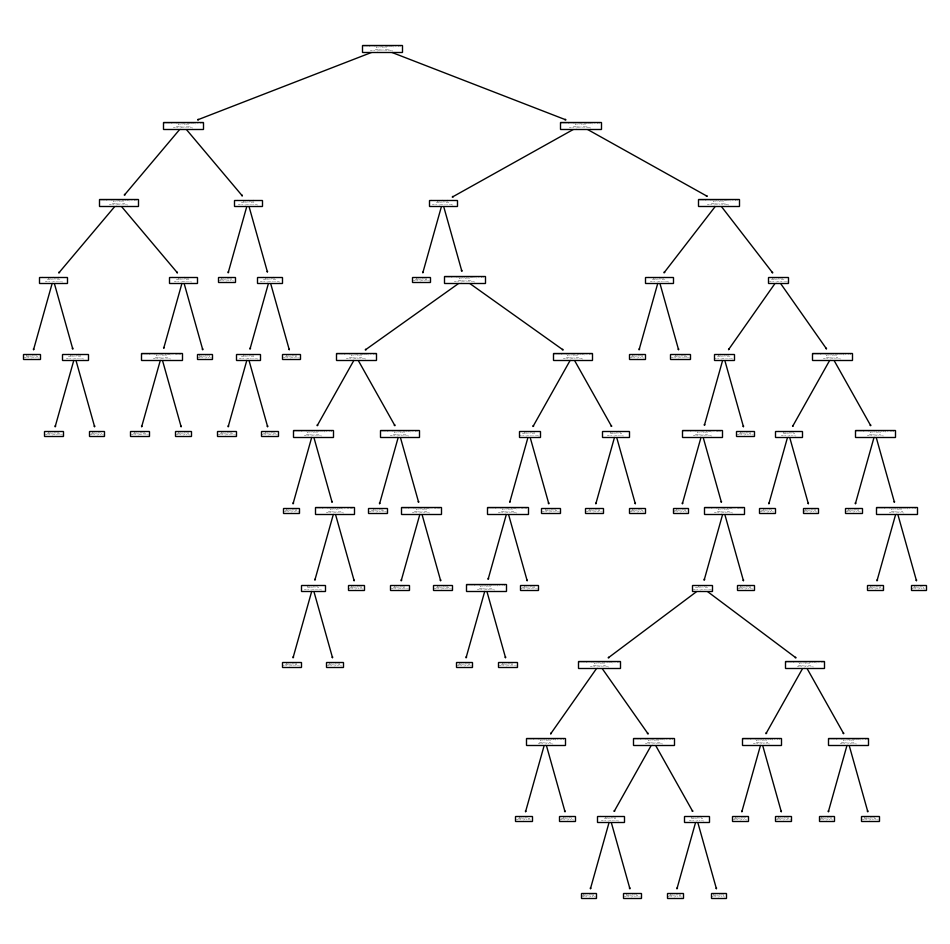

In [51]:
ax = subplots(figsize=(12, 12))[1]
plot_tree(pruned_tree,feature_names=feature_names ,ax=ax)

As we can see, the tree is too big for us to intepret the diagram. In fact, as we can see below, we have a lot of leaves.

In [52]:
pruned_tree.tree_.n_leaves

44

# Bagging

Bagging is a special case of Random Forest where we consider all predictors during each split instead of looking at a subset of them. Therefore, maximum number of features is just the number of predictors.

As increasing number of trees does not lead to overfitting, lets use a very large number of trees to be safe. We don't have to worry about time complexity because our dataset is small.

In [53]:
bagged_forest = RF(max_features = X_train.shape[1],n_estimators = 5000)
bagged_forest.fit(X_train,Y_train)

RandomForestClassifier(max_features=23, n_estimators=5000)

In [54]:
from math import sqrt
random_forest = RF(max_features = int(sqrt(X_train.shape[1])),n_estimators = 5000)
random_forest.fit(X_train,Y_train)

RandomForestClassifier(max_features=4, n_estimators=5000)

# Boosting

We will use stumps (i.e. n_estimators = 1) to control complexity. We use a small learning rate too. To decide optimal number of trees, we will use cross validation. We will increase number of trees in multiples of 50.

In [59]:
boosted_forest = GBC(max_depth=1,learning_rate=0.01)
kfold = skm.KFold(10,shuffle=True)
grid = skm.GridSearchCV(boosted_forest,{'n_estimators': list(range(100, 501, 50))},\
                        refit=True ,cv=kfold , scoring='accuracy')
grid.fit(X_train,Y_train)
grid.best_score_

0.7400409724556265

In [60]:
best_boosted_forest = grid.best_estimator_

# Getting Metrics to evaluate models

We will get accuracy, f11 score, and a confusion matrix. We will create reports of them.

In [63]:
def evaluate_classification_method(mod):
    y_pred = mod.predict(X_test)
    accuracy = accuracy_score(y_pred, y_test)
    f1 = f1_score(y_pred, y_test, average="weighted")
    labels = ["Dropout", "Enrolled", "Graduate"]
    full_report = classification_report(y_test, y_pred, target_names=labels)

    print(f"Accuracy classification score: {accuracy}")
    print(f"F1 score: {f1}")
    print(full_report)

    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot()
    return accuracy, f1, full_report, cm

Pruned Tree Report

Accuracy classification score: 0.7502824858757062
F1 score: 0.7509563704695728
              precision    recall  f1-score   support

     Dropout       0.83      0.65      0.73       284
    Enrolled       0.46      0.51      0.48       151
    Graduate       0.81      0.89      0.85       450

    accuracy                           0.75       885
   macro avg       0.70      0.69      0.69       885
weighted avg       0.76      0.75      0.75       885



/Users/joshuakoh/main_python_ve/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


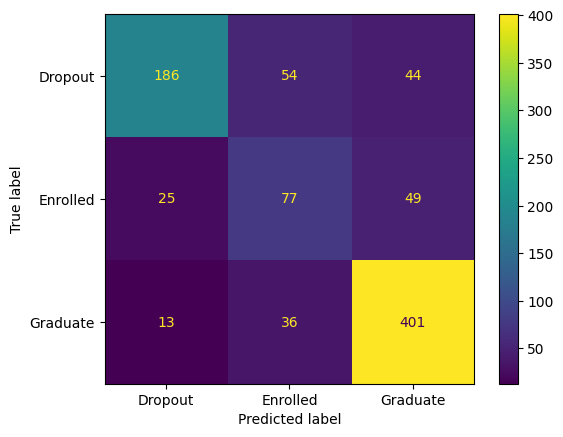

In [69]:
PT_accuracy, PT_f1, PT_full_report, PT_cm = evaluate_classification_method(pruned_tree)

Bagged Forest Report

/Users/joshuakoh/main_python_ve/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Accuracy classification score: 0.7943502824858757
F1 score: 0.8009919144849506
              precision    recall  f1-score   support

     Dropout       0.83      0.75      0.79       284
    Enrolled       0.57      0.47      0.51       151
    Graduate       0.83      0.93      0.88       450

    accuracy                           0.79       885
   macro avg       0.74      0.72      0.73       885
weighted avg       0.79      0.79      0.79       885



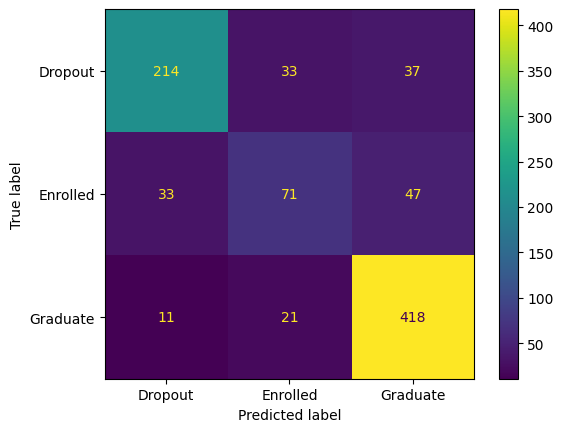

In [70]:
bagged_forest_accuracy, bagged_forest_f1, bagged_forest_full_report, bagged_forest_cm = \
    evaluate_classification_method(bagged_forest)

Random Forest Report

/Users/joshuakoh/main_python_ve/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Accuracy classification score: 0.7988700564971751
F1 score: 0.807605899003415
              precision    recall  f1-score   support

     Dropout       0.84      0.77      0.81       284
    Enrolled       0.61      0.45      0.52       151
    Graduate       0.82      0.93      0.87       450

    accuracy                           0.80       885
   macro avg       0.76      0.72      0.73       885
weighted avg       0.79      0.80      0.79       885



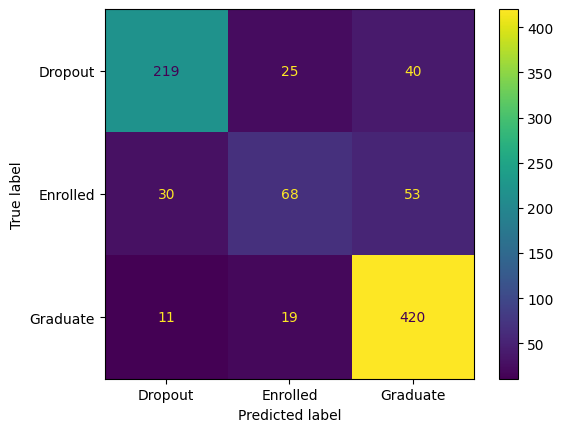

In [71]:
RF_accuracy, RF_f1, RF_full_report, RF_cm = evaluate_classification_method(random_forest)

Boosted Forest Report

Accuracy classification score: 0.7593220338983051
F1 score: 0.7860548470687536
              precision    recall  f1-score   support

     Dropout       0.76      0.75      0.76       284
    Enrolled       0.53      0.23      0.32       151
    Graduate       0.78      0.94      0.86       450

    accuracy                           0.76       885
   macro avg       0.69      0.64      0.64       885
weighted avg       0.73      0.76      0.73       885



/Users/joshuakoh/main_python_ve/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(


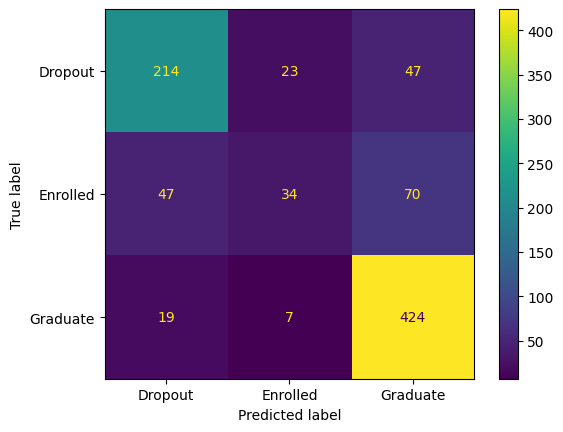

In [72]:
boosted_forest_accuracy, boosted_forest_f1, boosted_forest_full_report, boosted_forest_cm = \
    evaluate_classification_method(best_boosted_forest)

Looking at all the accuracies and F1 scores together

In [75]:
accuracies = [PT_accuracy,bagged_forest_accuracy,RF_accuracy,boosted_forest_accuracy]
f1_scores = [PT_f1,bagged_forest_f1,RF_f1,boosted_forest_f1]
models = ["Pruned Decision Tree","Bagged Forest","Random Forest","Boosted Forest"]

pd.DataFrame({"Model":models,\
              "Accuracy":[round(i,3) for i in accuracies],\
                "F1 Score":[round(i,3) for i in f1_scores]})

,Model,Accuracy,F1 Score
0,Pruned Decision Tree,0.750,0.751
1,Bagged Forest,0.794,0.801
2,Random Forest,0.799,0.808
3,Boosted Forest,0.759,0.786
